# Training with classic and stability loss

Recent work have shown that deep neural networks are sensible to adversarial perturbations: slight modifications of outputs, generally lower than sensor sampling resolution, that have the effect to fool classifiers. Those perturbations have shown intriguing properties:
+ Perturbed image is most of the time indistinguishible from the normal image
+ Perturbations are network agnostic: a perturbation desgined for a specific architecture can as weel perturb another one
+ Perturbations can be found in real world: a perturbed image printed and captured with camera still fools a network

In the recent paper [Improving the Robustness of Deep Neural Networks via Stability Training](https://arxiv.org/pdf/1604.04326v1.pdf), authors show two important things:
+ Perturbations can appear in computer vision pipelines, when compression, down sampling, and cropping operations are performed
+ The addition of a stability term to the loss function allows to reduce the robustness of classifiers

Indeed, when training a neural network over a classification task, one classicly use a regularized cross correlation between label and network output:
$$
L_c(x,y,\theta) = -\sum_{j}y_j\log(f(x,\theta)_j) + \beta\sum_{i}\|\theta_i\|^2
$$
With $f(x,\theta)_j$, the j-th output of the network for sample $x$. 

To enforce robustness of the network, the authors propose to add a term that penalize output modifications for slight modifications of the input, i.e. to add distance between output for normal sample, and output for modified sample to the loss:
$$
L_s(x,y,\theta) = -\sum_{j}y_j\log(f(x,\theta)_j) - \alpha\sum_{j}f(x,\theta)_j\log(f(x',\theta)_j) + \beta\sum_{i}\|\theta_i\|^2 
$$
With $x'$ the input image perturbed with gaussian noise. 

## Experiments

In this experiment, we are going to train classic LeNet5 architecture with classic and stabilized loss, and then assess the performance of each over perturbed samples.


In [1]:
import sys, os 
sys.path.append(os.getcwd()+'/../src')
sys.path.append(os.getcwd()+'/../data')

import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import architectures
import cifar10
import utils
import callbacks

We import data:

In [2]:
X_train, y_train_lab = cifar10.load_cifar(dataset='training', path=os.getcwd()+'/../data/cifar')
X_train = numpy.reshape(X_train, [X_train.shape[0], -1])
X_train = X_train/255.
X_train.astype(numpy.float32)
y_train = utils.labels_to_categoricals(y_train_lab)

X_test, y_test_lab = cifar10.load_cifar(dataset='testing', path=os.getcwd()+'/../data/cifar')
X_test = numpy.reshape(X_test, [X_test.shape[0], -1])
X_test = X_test/255.
X_test = X_test.astype(numpy.float32)
y_test = utils.labels_to_categoricals(y_test_lab)

We check that the data is in expected shape:

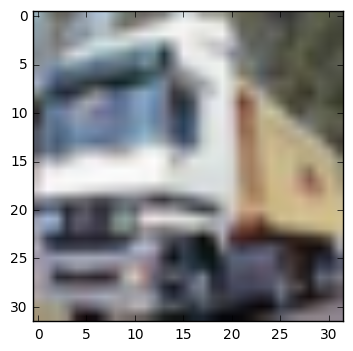

In [3]:
plt.imshow(numpy.reshape(X_train[1], [32,32,3]))

## Training Cifar Network with classic training
We instantiate the classicly trained CifarNet:

In [7]:
network = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')

We define our callback:

In [8]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/ct_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/ClassiclyTrained", over_iter=1000)

And then we train the network:

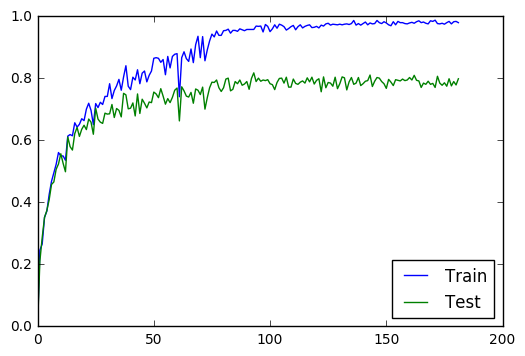

Number of iterations: 18200
Elapsed Time: 00:25:44
Last iteration duration: 8.53 seconds
Last train accuracy: 0.980000
Last test accuracy: 0.799000


In [9]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.1, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=2500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.0001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=1000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

We plot the Loss

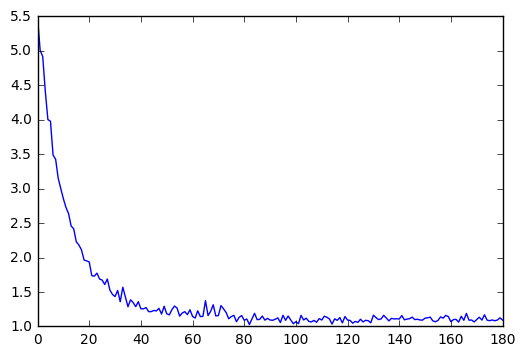

In [7]:
plt.plot(network.get_summaries(name="Loss/Loss_1"))
plt.savefig('Figures/ct_loss.pdf')

We plot the learning rate

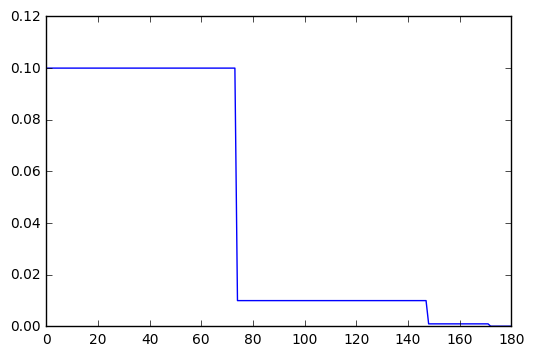

In [8]:
plt.plot(network.get_summaries(name="LearningRate_1"))
plt.savefig('Figures/ct_lr.pdf')

We save the network:

In [10]:
network.save("Networks/ClassiclyTrained")

We test the final accuracy over the whole test set

In [11]:
network.test(X_test, y_test)

0.7892

## Training Cifar Net with stabilized training
We train stabilized Cifar net with the following different configurations:
1. $\alpha$ = 0.01, $\sigma$ = 0.05
2. $\alpha$ = 0.01, $\sigma$ = 0.2
3. $\alpha$ = 0.1, $\sigma$ = 0.05

#### Configuration 1:  $\alpha$ = 0.01, $\sigma$ = 0.05

In [4]:
network = architectures.StabilizedCifarNet(path_to_logs=os.getcwd()+'/Logs')
alpha = network.get_tensor('Alpha:0')
network.update_feed_dict_value(alpha,0.01, 'both')
stdv = network.get_tensor('NoiseStdv:0')
network.update_feed_dict_value(stdv,0.05, 'both')

We define our callback:

In [5]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/st1_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/StabilityTrained1", over_iter=1000)

And then we train our network:

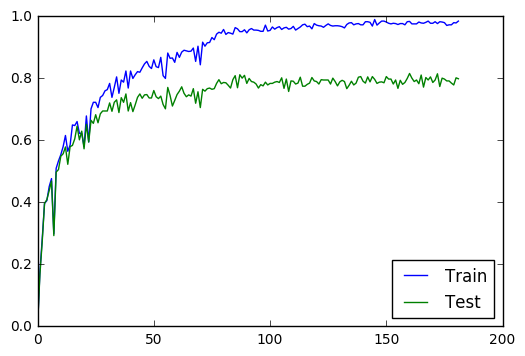

Number of iterations: 18200
Elapsed Time: 00:26:28
Last iteration duration: 8.77 seconds
Last train accuracy: 0.985000
Last test accuracy: 0.799000


In [6]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.1, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=2500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.0001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=1000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

We plot the Learning rate

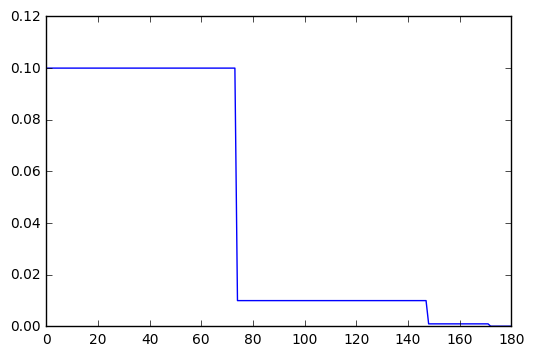

In [6]:
plt.plot(network.get_summaries('LearningRate_1'))
plt.savefig('Figures/st1_lr.pdf')

We plot the Stability loss

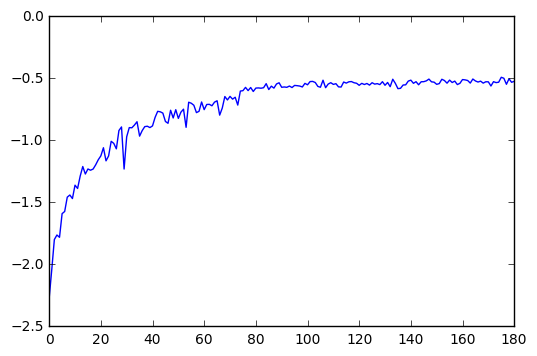

In [7]:
plt.plot(network.get_summaries('Loss/Stability_1'))
plt.savefig('Figures/st1_stability.pdf')

We plot the loss

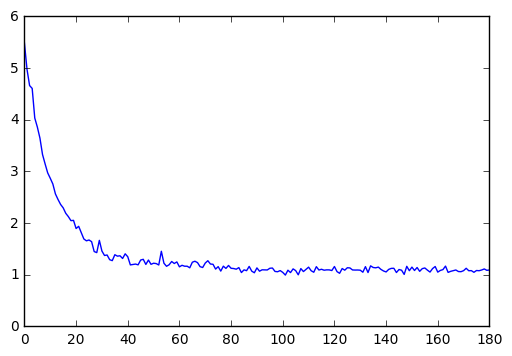

In [8]:
plt.plot(network.get_summaries('Loss/Loss_1'))
plt.savefig('Figures/st1_loss.pdf')

We save the network

In [9]:
network.save('Networks/StabilityTrained1')

We check the final test accuracy:

In [23]:
network.test(X_test, y_test)

0.78920000000000001

#### Configuration 2:  $\alpha$ = 0.01, $\sigma$ = 0.2

In [41]:
network = architectures.StabilizedCifarNet(path_to_logs=os.getcwd()+'/Logs')
alpha = network.get_tensor('Alpha:0')
network.update_feed_dict_value(alpha,0.01, 'both')
stdv = network.get_tensor('NoiseStdv:0')
network.update_feed_dict_value(stdv,0.2, 'both')

In [42]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/st2_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/StabilityTrained2", over_iter=1000)

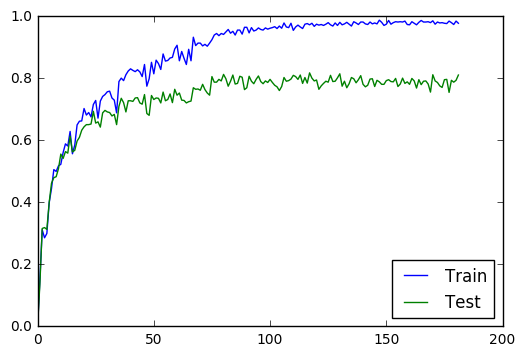

Number of iterations: 18200
Elapsed Time: 00:25:43
Last iteration duration: 8.55 seconds
Last train accuracy: 0.978000
Last test accuracy: 0.811000


In [43]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.1, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=2500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.0001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=1000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

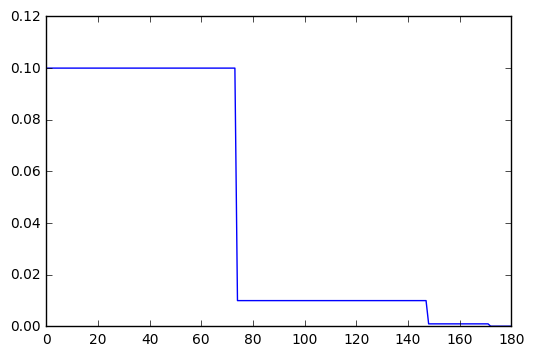

In [44]:
plt.plot(network.get_summaries('LearningRate_1'))
plt.savefig('Figures/st2_lr.pdf')

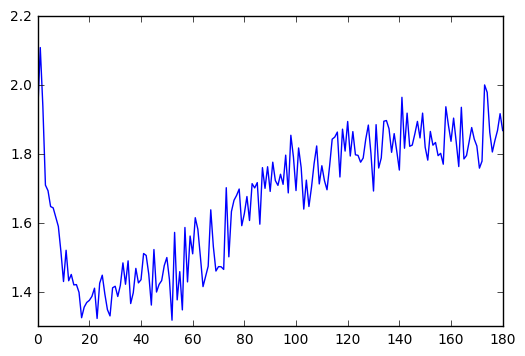

In [45]:
plt.plot(network.get_summaries('Loss/Stability_1'))
plt.savefig('Figures/st2_stability.pdf')

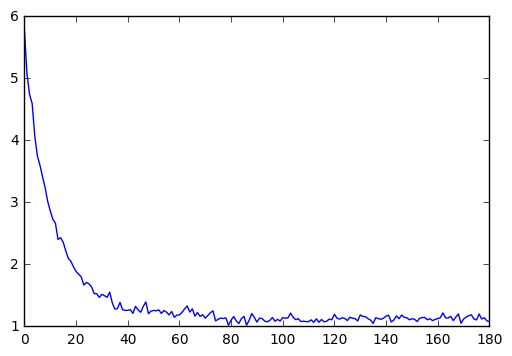

In [46]:
plt.plot(network.get_summaries('Loss/Loss_1'))
plt.savefig('Figures/st2_loss.pdf')

In [47]:
network.save('Networks/StabilityTrained2')

In [48]:
network.test(X_test, y_test)

0.79169999999999996

#### Configuration 3:  $\alpha$ = 0.1, $\sigma$ = 0.05

In [32]:
network = architectures.StabilizedCifarNet(path_to_logs=os.getcwd()+'/Logs')
alpha = network.get_tensor('Alpha:0')
network.update_feed_dict_value(alpha,0.1, 'both')
stdv = network.get_tensor('NoiseStdv:0')
network.update_feed_dict_value(stdv,0.05, 'both')

In [33]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/st3_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/StabilityTrained3", over_iter=1000)

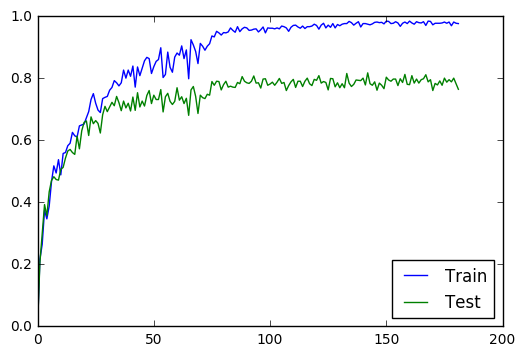

Number of iterations: 18200
Elapsed Time: 00:25:42
Last iteration duration: 8.53 seconds
Last train accuracy: 0.977000
Last test accuracy: 0.765000


In [34]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.1, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=2500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.0001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=1000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

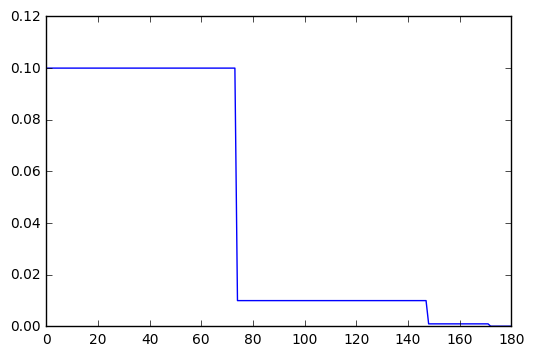

In [35]:
plt.plot(network.get_summaries('LearningRate_1'))
plt.savefig('Figures/st3_lr.pdf')

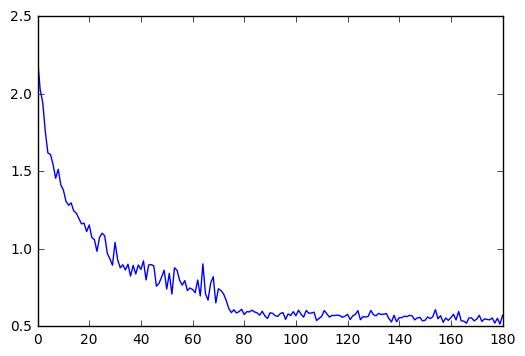

In [36]:
plt.plot(network.get_summaries('Loss/Stability_1'))
plt.savefig('Figures/st3_stability.pdf')

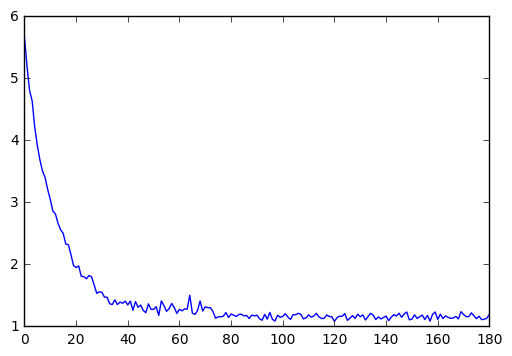

In [37]:
plt.plot(network.get_summaries('Loss/Loss_1'))
plt.savefig('Figures/st3_loss.pdf')

In [40]:
network.save('Networks/StabilityTrained3')

In [39]:
network.test(X_test, y_test)

0.79110000000000003